In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=1de5e240a3e39579a1ebfd2d579d0bf01f4c9f6e3910c424e4f75adc9d674823
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
from statsmodels.regression.rolling import RollingOLS;
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [ ]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0];
sp500['Symbol'] = sp500['Symbol'].replace('.','-')

symbols_list = sp500['Symbol'].unique().tolist();
end_date = '2024-03-23'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)
start_date

Timestamp('2016-03-25 00:00:00')

In [ ]:
df = yf.download(tickers = symbols_list,
                 start = start_date,
                 end = end_date).stack()



[*********************100%%**********************]  503 of 503 completed
ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2016-03-25 00:00:00 -> 2024-03-23)')
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
ERROR:yfinance:['GEV', 'SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1458878400, endDate = 1711166400")


In [ ]:
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

#Garman-Klass Volatility

It is a volatility measure; an extension of the Parkinson volatility by including the open, close, high and low prices of a stock at a given date.
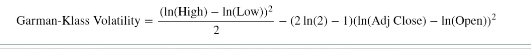

In [ ]:
df['garman_kloss_vol'] =((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# Other Tech Indicators

*   Relative Strength Index (RSI)
*   Bollinger Bands
*   Average True Range (ATR)
*   Moving Average Convergence Divergence (MACD)
*   Dollar Volume







In [ ]:
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: np.log1p(pandas_ta.rsi(close=x)))

df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x)).iloc[:,0])
df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x)).iloc[:,1])
df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x)).iloc[:,2])


In [ ]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std()) ##this normalises the data in the column
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)



In [ ]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

In [ ]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6 ## Dollar volume in millions

In [ ]:
df.xs('AAPL', level =1)

Price,adj close,close,high,low,open,volume,garman_kloss_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dollar_volume
date,,,,,,,,,,,,,,
2016-03-28,24.040295,26.297501,26.547501,26.264999,26.500000,77645600.0,-0.003608,NaN,NaN,NaN,NaN,NaN,NaN,1866.623102
2016-03-29,24.609362,26.920000,26.947500,26.219999,26.222500,124760400.0,-0.001183,NaN,NaN,NaN,NaN,NaN,NaN,3070.273803
2016-03-30,25.039024,27.389999,27.605000,27.150000,27.162500,182404400.0,-0.002422,NaN,NaN,NaN,NaN,NaN,NaN,4567.228214
2016-03-31,24.908751,27.247499,27.475000,27.219999,27.430000,103553600.0,-0.003548,NaN,NaN,NaN,NaN,NaN,NaN,2579.390789
2016-04-01,25.137297,27.497499,27.500000,27.049999,27.195000,103496000.0,-0.002255,NaN,3.217264,3.248197,3.279130,NaN,NaN,2601.609657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-18,173.720001,173.720001,177.710007,173.520004,175.570007,75604200.0,0.000241,3.720720,5.147390,5.157547,5.167704,0.772731,-1.979356,13133.961716
2024-03-19,176.080002,176.080002,176.610001,173.029999,174.339996,55215200.0,0.000172,3.863045,5.142215,5.160792,5.179369,0.781405,-1.766397,9722.292517
2024-03-20,178.669998,178.669998,178.669998,175.089996,175.720001,53423100.0,0.000098,3.980492,5.143655,5.169366,5.195078,0.789461,-1.481159,9545.105179


# Aggregating the values

Creating a top 150 liquid stocks based on dollar volume 5-year rolling average for each day and simplifying the dataframe to the indicators.

In [ ]:
important_cols = [col for col in df.columns.unique(0) if col not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

In [ ]:
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[important_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

## returns take last to ensure its a monthly closing pattern, wouldn't make sense for dollar volume, so mean is calculated

In [ ]:
data['dollar_volume'] = (data['dollar_volume'].unstack('ticker').rolling(5*12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2021-04-30 AAL      21.719999  0.005117  3.143363  3.101611  3.122487   
           AAPL    129.206757  0.365091  4.901504  4.867621  4.884562   
           ABBV     99.838547 -0.430897  4.618780  4.607009  4.612895   
           ABT     114.346916  0.479006  4.771891  4.745041  4.758466   
           ACN     278.951019 -0.307273  5.643652  5.629272  5.636462   
...                       ...       ...       ...       ...       ...   
2024-03-31 WFC      57.130001 -0.160137  4.079095  4.055914  4.067505   
           WMT      60.869999  0.268979  4.135984  4.120204  4.128094   
           XOM     113.489998 -0.085597  4.744486  4.729159  4.736822   
           ZTS     168.899994  1.034330  5.162986  5.124595  5.143791   
           MRNA    105.430000 -0.468255  4.673394  4.641955  4.657675   

                   garman_kloss_vol      macd       rsi  dollar_vol_rank  
date       ticker                                                         
2021-04-30 AAL             0.000440 -0.256388  3.892809             68.0  
           AAPL            0.000027  0.695226  3.973352              2.0  
           ABBV           -0.004496  0.592161  4.173741             52.0  
           ABT            -0.000949  0.108676  3.853082             75.0  
           ACN            -0.000626  1.111596  4.185951             97.0  
...                             ...       ...       ...              ...  
2024-03-31 WFC             0.000068  1.662901  4.173621             32.0  
           WMT             0.000041  1.982052  4.183306             33.0  
           XOM             0.000030  2.128755  4.348906             17.0  
           ZTS             0.000177 -2.790276  3.408540            148.0  
           MRNA            0.000215  0.225045  4.067301             21.0  

[5364 rows x 9 columns]

In [ ]:
def calculate_returns(df):
  outlier_cutoff = 0.005
  lags = [1,2,3,6,9,12]
  for lag in lags:
    df[f'return_{lag}'] = (df['adj close']
                          .pct_change(lag)
                          .pipe((lambda x: x.clip(lower = x.quantile(outlier_cutoff), upper = x.quantile(1-outlier_cutoff))))
                          .add(1)
                          .pow(1/lag)
                          .sub(1))
  return df

In [ ]:
data = data.groupby('ticker', group_keys = False).apply(calculate_returns).dropna()

In [ ]:
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2022-05-31 AAL      17.870001  0.000374  3.000781  2.773875  2.887328   
           AAPL    147.374527  2.300766  5.025224  4.916494  4.970859   
           ABBV    137.606705  2.031877  4.968126  4.927554  4.947840   
           ABT     113.559715  1.576626  4.749969  4.693441  4.721705   
           ACN     290.394440  2.121547  5.715727  5.579427  5.647577   
...                       ...       ...       ...       ...       ...   
2024-03-31 VRTX    415.660004  0.790102  6.037336  6.019258  6.028297   
           VZ       40.369999 -0.628603  3.729474  3.706690  3.718082   
           WFC      57.130001 -0.160137  4.079095  4.055914  4.067505   
           WMT      60.869999  0.268979  4.135984  4.120204  4.128094   
           XOM     113.489998 -0.085597  4.744486  4.729159  4.736822   

                   garman_kloss_vol      macd       rsi  dollar_vol_rank  \
date       ticker                                                          
2022-05-31 AAL             0.000755 -0.139096  3.994352             68.0   
           AAPL            0.000279 -2.359879  3.898725              3.0   
           ABBV           -0.002186 -1.185083  3.685446             48.0   
           ABT             0.000386 -0.251407  4.071749             75.0   
           ACN            -0.000390 -1.543770  3.974152             83.0   
...                             ...       ...       ...              ...   
2024-03-31 VRTX            0.000080 -0.938697  3.902774            111.0   
           VZ              0.000164 -0.048811  3.996915             42.0   
           WFC             0.000068  1.662901  4.173621             32.0   
           WMT             0.000041  1.982052  4.183306             33.0   
           XOM             0.000030  2.128755  4.348906             17.0   

                   return_1  return_2  return_3  return_6  return_9  return_12  
date       ticker                                                               
2022-05-31 AAL    -0.047949 -0.010466  0.011840  0.001689 -0.012104  -0.025087  
           AAPL   -0.054496 -0.076059 -0.033536 -0.016881 -0.001742   0.015399  
           ABBV    0.003336 -0.042503  0.001919  0.045047  0.025864   0.025803  
           ABT     0.034890 -0.001826 -0.007495 -0.010092 -0.006839   0.001841  
           ACN    -0.006326 -0.057838 -0.017903 -0.028690 -0.012325   0.005641  
...                     ...       ...       ...       ...       ...        ...  
2024-03-31 VRTX   -0.012074 -0.020657  0.007134  0.030182  0.018671   0.023358  
           VZ      0.008746 -0.023656  0.028790  0.043787  0.015410   0.009093  
           WFC     0.027703  0.070747  0.053386  0.059335  0.035650   0.036577  
           WMT     0.042097  0.053004  0.050824  0.023561  0.018007   0.019208  
           XOM     0.085821  0.055528  0.046375 -0.002838  0.009273   0.005807  

[3262 rows x 15 columns]